In [1]:
!pip install -q tensorflow-datasets "jax[cuda12]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

In [2]:
import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

2025-05-31 02:58:05.463563: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-31 02:58:05.480744: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-31 02:58:05.486005: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-31 02:58:06.462137: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
class NeuralNetUtils:
    """Utility functions for neural network operations"""
    
    @staticmethod
    def init_linear_layer(key, input_dim, output_dim):
        """Initialize a linear layer with Xavier initialization"""
        key1, key2 = random.split(key)
        std = jnp.sqrt(2.0 / (input_dim + output_dim))
        W = random.normal(key1, (input_dim, output_dim)) * std
        b = jnp.zeros(output_dim)
        return {'W': W, 'b': b}

    @staticmethod
    def linear_forward(params, x):
        """Forward pass through linear layer"""
        return jnp.dot(x, params['W']) + params['b']

    @staticmethod
    def init_conv2d_layer(key, in_channels, out_channels, kernel_size):
        """Initialize a 2D convolution layer"""
        fan_in = in_channels * kernel_size * kernel_size
        std = jnp.sqrt(2.0 / fan_in)
        W = random.normal(key, (kernel_size, kernel_size, in_channels, out_channels)) * std
        b = jnp.zeros(out_channels)
        return {'W': W, 'b': b}

    @staticmethod
    def conv2d_forward(params, x, stride=1, padding='SAME'):
        """Forward pass through conv2d layer"""
        out = jax.lax.conv_general_dilated(
            x, params['W'],
            window_strides=(stride, stride),
            padding=padding,
            dimension_numbers=('NHWC', 'HWIO', 'NHWC')
        )
        return out + params['b']

    @staticmethod
    def group_norm_forward(x, num_groups=8, eps=1e-5):
        """Group normalization"""
        batch_size, height, width, channels = x.shape
        
        # Ensure we don't have more groups than channels
        num_groups = min(num_groups, channels)
        if channels % num_groups != 0:
            # Find the largest divisor of channels that's <= num_groups
            for g in range(min(num_groups, channels), 0, -1):
                if channels % g == 0:
                    num_groups = g
                    break
            
        x_reshaped = x.reshape(batch_size, height, width, num_groups, channels // num_groups)
        mean = jnp.mean(x_reshaped, axis=(1, 2, 4), keepdims=True)
        var = jnp.var(x_reshaped, axis=(1, 2, 4), keepdims=True)
        x_norm = (x_reshaped - mean) / jnp.sqrt(var + eps)
        return x_norm.reshape(batch_size, height, width, channels)

    @staticmethod
    def swish(x):
        """Swish activation function"""
        return x * jax.nn.sigmoid(x)

    @staticmethod
    def sinusoidal_pos_embedding(timesteps, dim):
        """Create sinusoidal position embeddings"""
        half_dim = dim // 2
        emb = jnp.log(10000) / (half_dim - 1)
        emb = jnp.exp(jnp.arange(half_dim) * -emb)
        emb = timesteps[:, None] * emb[None, :]
        emb = jnp.concatenate([jnp.sin(emb), jnp.cos(emb)], axis=-1)
        return emb

In [4]:
class SimpleUNet:
    """Simplified U-Net architecture for diffusion models"""
    
    def __init__(self, dim=128, dim_mults=(1, 2)):
        self.dim = dim
        self.dim_mults = dim_mults
        self.time_dim = dim * 4
    
    def init_params(self, key):
        """Initialize U-Net parameters"""
        keys = random.split(key, 50)
        key_idx = 0
        
        params = {}
        
        # Time embedding
        params['time_embed'] = {
            'linear1': NeuralNetUtils.init_linear_layer(keys[key_idx], self.dim, self.time_dim),
            'linear2': NeuralNetUtils.init_linear_layer(keys[key_idx + 1], self.time_dim, self.time_dim)
        }
        key_idx += 2
        
        # Initial conv
        params['init_conv'] = NeuralNetUtils.init_conv2d_layer(keys[key_idx], 1, self.dim, 3)
        key_idx += 1
        
        # Encoder
        params['encoder'] = {}
        for i, mult in enumerate(self.dim_mults):
            dim_out = self.dim * mult
            dim_in = self.dim if i == 0 else self.dim * self.dim_mults[i-1]
            
            params['encoder'][f'conv1_{i}'] = NeuralNetUtils.init_conv2d_layer(keys[key_idx], dim_in, dim_out, 3)
            params['encoder'][f'conv2_{i}'] = NeuralNetUtils.init_conv2d_layer(keys[key_idx + 1], dim_out, dim_out, 3)
            params['encoder'][f'time_proj_{i}'] = NeuralNetUtils.init_linear_layer(keys[key_idx + 2], self.time_dim, dim_out)
            
            if i < len(self.dim_mults) - 1:
                params['encoder'][f'downsample_{i}'] = NeuralNetUtils.init_conv2d_layer(keys[key_idx + 3], dim_out, dim_out, 3)
                key_idx += 4
            else:
                key_idx += 3
        
        # Middle
        middle_dim = self.dim * self.dim_mults[-1]
        params['middle'] = {
            'conv1': NeuralNetUtils.init_conv2d_layer(keys[key_idx], middle_dim, middle_dim, 3),
            'conv2': NeuralNetUtils.init_conv2d_layer(keys[key_idx + 1], middle_dim, middle_dim, 3),
            'time_proj': NeuralNetUtils.init_linear_layer(keys[key_idx + 2], self.time_dim, middle_dim)
        }
        key_idx += 3
        
        # Decoder
        params['decoder'] = {}
        for i, mult in enumerate(reversed(self.dim_mults)):
            dim_out = self.dim * mult
            
            if i > 0:
                dim_in_prev = self.dim * list(reversed(self.dim_mults))[i-1]
                params['decoder'][f'upsample_{i}'] = NeuralNetUtils.init_conv2d_layer(keys[key_idx], dim_in_prev, dim_out, 3)
                key_idx += 1
                # After skip connection concatenation
                dim_in = dim_out * 2
            else:
                # First decoder layer - no upsampling, but has skip connection
                dim_in = middle_dim + dim_out  # middle + skip
            
            params['decoder'][f'conv1_{i}'] = NeuralNetUtils.init_conv2d_layer(keys[key_idx], dim_in, dim_out, 3)
            params['decoder'][f'conv2_{i}'] = NeuralNetUtils.init_conv2d_layer(keys[key_idx + 1], dim_out, dim_out, 3)
            params['decoder'][f'time_proj_{i}'] = NeuralNetUtils.init_linear_layer(keys[key_idx + 2], self.time_dim, dim_out)
            key_idx += 3
        
        # Final conv
        params['final_conv'] = NeuralNetUtils.init_conv2d_layer(keys[key_idx], self.dim, 1, 3)
        
        return params
    
    def forward(self, params, x, time_steps):
        """Forward pass through U-Net"""
        # Time embedding
        time_emb = NeuralNetUtils.sinusoidal_pos_embedding(time_steps, self.dim)
        time_emb = NeuralNetUtils.linear_forward(params['time_embed']['linear1'], time_emb)
        time_emb = NeuralNetUtils.swish(time_emb)
        time_emb = NeuralNetUtils.linear_forward(params['time_embed']['linear2'], time_emb)
        
        # Initial conv
        x = NeuralNetUtils.conv2d_forward(params['init_conv'], x)
        
        # Encoder
        skip_connections = []
        for i, mult in enumerate(self.dim_mults):
            # Conv blocks with time embedding
            h = NeuralNetUtils.group_norm_forward(x)
            h = NeuralNetUtils.swish(h)
            h = NeuralNetUtils.conv2d_forward(params['encoder'][f'conv1_{i}'], h)
            
            # Add time embedding
            t_emb = NeuralNetUtils.linear_forward(params['encoder'][f'time_proj_{i}'], time_emb)
            h = h + t_emb[:, None, None, :]
            
            h = NeuralNetUtils.group_norm_forward(h)
            h = NeuralNetUtils.swish(h)
            h = NeuralNetUtils.conv2d_forward(params['encoder'][f'conv2_{i}'], h)
            
            # Skip connection
            x = x + h if x.shape[-1] == h.shape[-1] else h
            skip_connections.append(x)
            
            # Downsample
            if i < len(self.dim_mults) - 1:
                x = NeuralNetUtils.conv2d_forward(params['encoder'][f'downsample_{i}'], x, stride=2)
        
        # Middle
        h = NeuralNetUtils.group_norm_forward(x)
        h = NeuralNetUtils.swish(h)
        h = NeuralNetUtils.conv2d_forward(params['middle']['conv1'], h)
        
        t_emb = NeuralNetUtils.linear_forward(params['middle']['time_proj'], time_emb)
        h = h + t_emb[:, None, None, :]
        
        h = NeuralNetUtils.group_norm_forward(h)
        h = NeuralNetUtils.swish(h)
        h = NeuralNetUtils.conv2d_forward(params['middle']['conv2'], h)
        
        x = x + h
        
        # Decoder
        for i, mult in enumerate(reversed(self.dim_mults)):
            # Upsample
            if i > 0:
                batch_size, height, width, channels = x.shape
                x = jax.image.resize(x, (batch_size, height * 2, width * 2, channels), method='nearest')
                x = NeuralNetUtils.conv2d_forward(params['decoder'][f'upsample_{i}'], x)
            
            # Skip connection
            skip = skip_connections.pop()
            if x.shape[1] != skip.shape[1] or x.shape[2] != skip.shape[2]:
                target_shape = (x.shape[0], skip.shape[1], skip.shape[2], x.shape[3])
                x = jax.image.resize(x, target_shape, method='bilinear')
            
            x = jnp.concatenate([x, skip], axis=-1)
            
            # Conv blocks with time embedding
            h = NeuralNetUtils.group_norm_forward(x)
            h = NeuralNetUtils.swish(h)
            h = NeuralNetUtils.conv2d_forward(params['decoder'][f'conv1_{i}'], h)
            
            t_emb = NeuralNetUtils.linear_forward(params['decoder'][f'time_proj_{i}'], time_emb)
            h = h + t_emb[:, None, None, :]
            
            h = NeuralNetUtils.group_norm_forward(h)
            h = NeuralNetUtils.swish(h)
            x = NeuralNetUtils.conv2d_forward(params['decoder'][f'conv2_{i}'], h)
        
        # Final conv
        x = NeuralNetUtils.group_norm_forward(x)
        x = NeuralNetUtils.swish(x)
        x = NeuralNetUtils.conv2d_forward(params['final_conv'], x)
        
        return x

In [5]:
class DiffusionModel:
    """Complete diffusion model implementation"""
    
    def __init__(self, timesteps=1000, unet_dim=128, unet_dim_mults=(1, 2)):
        self.timesteps = timesteps
        self.unet = SimpleUNet(dim=unet_dim, dim_mults=unet_dim_mults)
        self.schedule = self._create_diffusion_schedule()
    
    def _create_diffusion_schedule(self):
        """Create diffusion schedule parameters"""
        betas = jnp.linspace(1e-4, 0.02, self.timesteps)
        alphas = 1.0 - betas
        alphas_cumprod = jnp.cumprod(alphas)
        alphas_cumprod_prev = jnp.concatenate([jnp.array([1.0]), alphas_cumprod[:-1]])
        
        sqrt_alphas_cumprod = jnp.sqrt(alphas_cumprod)
        sqrt_one_minus_alphas_cumprod = jnp.sqrt(1.0 - alphas_cumprod)
        posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
        
        return {
            'betas': betas,
            'alphas': alphas,
            'alphas_cumprod': alphas_cumprod,
            'sqrt_alphas_cumprod': sqrt_alphas_cumprod,
            'sqrt_one_minus_alphas_cumprod': sqrt_one_minus_alphas_cumprod,
            'posterior_variance': posterior_variance
        }
    
    def init_params(self, key):
        """Initialize model parameters"""
        return self.unet.init_params(key)
    
    def q_sample(self, x_start, t, noise):
        """Forward diffusion process: q(x_t | x_0)"""
        sqrt_alphas_cumprod_t = self.schedule['sqrt_alphas_cumprod'][t]
        sqrt_one_minus_alphas_cumprod_t = self.schedule['sqrt_one_minus_alphas_cumprod'][t]
        
        sqrt_alphas_cumprod_t = sqrt_alphas_cumprod_t.reshape(-1, 1, 1, 1)
        sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod_t.reshape(-1, 1, 1, 1)
        
        return (sqrt_alphas_cumprod_t * x_start + 
                sqrt_one_minus_alphas_cumprod_t * noise)
    
    def compute_loss(self, params, x_start, t, noise, key):
        """Calculate training loss"""
        x_noisy = self.q_sample(x_start, t, noise)
        predicted_noise = self.unet.forward(params, x_noisy, t)
        loss = jnp.mean((noise - predicted_noise) ** 2)
        return loss
    
    def p_sample(self, params, x, t, key):
        """Single denoising step"""
        betas_t = self.schedule['betas'][t].reshape(-1, 1, 1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.schedule['sqrt_one_minus_alphas_cumprod'][t].reshape(-1, 1, 1, 1)
        sqrt_recip_alphas_t = jnp.sqrt(1.0 / self.schedule['alphas'][t]).reshape(-1, 1, 1, 1)
        
        predicted_noise = self.unet.forward(params, x, t)
        model_mean = sqrt_recip_alphas_t * (x - betas_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t)
        
        if jnp.all(t == 0):
            return model_mean
        else:
            posterior_variance_t = self.schedule['posterior_variance'][t].reshape(-1, 1, 1, 1)
            noise = random.normal(key, x.shape)
            return model_mean + jnp.sqrt(posterior_variance_t) * noise
    
    def p_sample_loop(self, params, shape, key):
        """Generate samples by denoising from pure noise"""
        img = random.normal(key, shape)
        
        for i in reversed(range(self.timesteps)):
            key, subkey = random.split(key)
            t = jnp.full((shape[0],), i, dtype=jnp.int32)
            img = self.p_sample(params, img, t, subkey)
        
        return img
    
    def generate_samples(self, params, num_samples, key):
        """Generate samples"""
        return self.p_sample_loop(params, (num_samples, 28, 28, 1), key)

In [6]:
class AdamOptimizer:
    """Adam optimizer implementation"""
    
    def __init__(self, learning_rate=1e-4, beta1=0.9, beta2=0.999, eps=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
    
    def init_state(self, params):
        """Initialize optimizer state"""
        m = jax.tree.map(jnp.zeros_like, params)
        v = jax.tree.map(jnp.zeros_like, params)
        return {'m': m, 'v': v, 'step': 0}
    
    def update(self, grads, state, params):
        """Update parameters using Adam optimizer"""
        step = state['step'] + 1
        
        # Update biased first and second moment estimates
        m = jax.tree.map(lambda m, g: self.beta1 * m + (1 - self.beta1) * g, state['m'], grads)
        v = jax.tree.map(lambda v, g: self.beta2 * v + (1 - self.beta2) * g**2, state['v'], grads)
        
        # Bias correction
        m_hat = jax.tree.map(lambda m: m / (1 - self.beta1**step), m)
        v_hat = jax.tree.map(lambda v: v / (1 - self.beta2**step), v)
        
        # Update parameters
        params = jax.tree.map(
            lambda p, m, v: p - self.learning_rate * m / (jnp.sqrt(v) + self.eps),
            params, m_hat, v_hat
        )
        
        new_state = {'m': m, 'v': v, 'step': step}
        return params, new_state

In [7]:
class DiffusionTrainer:
    """Trainer class for diffusion models"""
    
    def __init__(self, diffusion_model, optimizer, batch_size=128):
        self.diffusion_model = diffusion_model
        self.optimizer = optimizer
        self.batch_size = batch_size
    
    @staticmethod
    def load_mnist():
        """Load and preprocess MNIST data"""
        (x_train, _), (x_test, _) = mnist.load_data()
        x_train = x_train.astype(np.float32) / 255.0
        x_train = x_train[..., None]  # Add channel dimension
        x_train = (x_train - 0.5) / 0.5  # Normalize to [-1, 1]
        return x_train
    
    def train_step(self, params, opt_state, batch, key):
        """Single training step"""
        def loss_fn(params):
            batch_size = batch.shape[0]
            key_t, key_noise = random.split(key)
            
            t = random.randint(key_t, (batch_size,), 0, self.diffusion_model.timesteps)
            noise = random.normal(key_noise, batch.shape)
            
            return self.diffusion_model.compute_loss(params, batch, t, noise, key)
        
        loss, grads = jax.value_and_grad(loss_fn)(params)
        params, opt_state = self.optimizer.update(grads, opt_state, params)
        
        return params, opt_state, loss
    
    def generate_and_plot_samples(self, params, epoch, key, num_samples=16):
        """Generate and plot samples in a grid"""
        print(f"\nGenerating {num_samples} samples at epoch {epoch}...")
        samples = self.diffusion_model.generate_samples(params, num_samples, key)
        
        samples = (samples * 0.5 + 0.5)
        samples = jnp.clip(samples, 0, 1)
        
        grid_size = int(np.sqrt(num_samples))
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
        
        for i in range(num_samples):
            row = i // grid_size
            col = i % grid_size
            ax = axes[row, col]
            ax.imshow(samples[i, :, :, 0], cmap='gray')
            ax.axis('off')
        
        plt.suptitle(f'Generated MNIST Samples - Epoch {epoch}', fontsize=16)
        plt.tight_layout()
        plt.show()
    
    def train(self, num_epochs=50, sample_every=10):
        """Main training loop"""
        key = random.PRNGKey(42)
        key, init_key = random.split(key)
        
        print("Loading MNIST dataset...")
        x_train = self.load_mnist()
        print(f"Dataset loaded: {x_train.shape[0]} training samples")
        
        print("Initializing model...")
        params = self.diffusion_model.init_params(init_key)
        opt_state = self.optimizer.init_state(params)
        
        # JIT compile the training step for better performance
        self.train_step = jit(self.train_step)
        
        num_batches = len(x_train) // self.batch_size
        
        print(f"Starting training for {num_epochs} epochs...")
        print(f"Batches per epoch: {num_batches}")
        print(f"Batch size: {self.batch_size}")
        
        epoch_losses = []
        
        for epoch in range(num_epochs):
            key, shuffle_key = random.split(key)
            perm = random.permutation(shuffle_key, len(x_train))
            x_train_shuffled = x_train[perm]
            
            epoch_loss = 0.0
            
            batch_pbar = tqdm(range(num_batches), 
                             desc=f"Epoch {epoch+1}/{num_epochs}", 
                             leave=False)
            
            for i in batch_pbar:
                batch = x_train_shuffled[i*self.batch_size:(i+1)*self.batch_size]
                key, train_key = random.split(key)
                params, opt_state, loss = self.train_step(params, opt_state, batch, train_key)
                epoch_loss += loss
                
                batch_pbar.set_postfix({'Loss': f'{loss:.4f}'})
            
            avg_loss = epoch_loss / num_batches
            epoch_losses.append(avg_loss)
            
            print(f"Epoch {epoch+1}/{num_epochs} completed. Average loss: {avg_loss:.4f}")
            
            if epoch % sample_every == 0:
                key, sample_key = random.split(key)
                self.generate_and_plot_samples(params, epoch, sample_key, num_samples=16)
        
        # Plot training loss
        plt.figure(figsize=(10, 6))
        plt.plot(epoch_losses)
        plt.title('Training Loss Over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Average Loss')
        plt.grid(True)
        plt.show()
        
        return params


In [8]:
def main():
    """Main execution function"""
    # Initialize components with simpler architecture
    diffusion_model = DiffusionModel(timesteps=1000, unet_dim=128, unet_dim_mults=(1, 2))
    optimizer = AdamOptimizer(learning_rate=1e-4)
    trainer = DiffusionTrainer(diffusion_model, optimizer, batch_size=64)  # Smaller batch size
    
    # Train the model
    trained_params = trainer.train(num_epochs=30, sample_every=5)  # Fewer epochs for testing
    
    # Generate final samples
    print("\nGenerating final 25 samples...")
    key = random.PRNGKey(123)
    final_samples = diffusion_model.generate_samples(trained_params, 25, key)
    
    final_samples = (final_samples * 0.5 + 0.5)
    final_samples = jnp.clip(final_samples, 0, 1)
    
    fig, axes = plt.subplots(5, 5, figsize=(12, 12))
    for i in range(25):
        ax = axes[i // 5, i % 5]
        ax.imshow(final_samples[i, :, :, 0], cmap='gray')
        ax.axis('off')
    plt.suptitle('Final Generated MNIST Digits - 25 Samples', fontsize=16)
    plt.tight_layout()
    plt.show()
    

Loading MNIST dataset...
Dataset loaded: 60000 training samples
Initializing model...
Starting training for 30 epochs...
Batches per epoch: 937
Batch size: 64


Epoch 1/30:   0%|          | 0/937 [00:00<?, ?it/s]2025-05-31 02:58:14.277297: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-05-31 02:58:14.277413: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-05-31 02:58:14.277431: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-05-31

Epoch 1/30 completed. Average loss: 0.0776

Generating 16 samples at epoch 0...


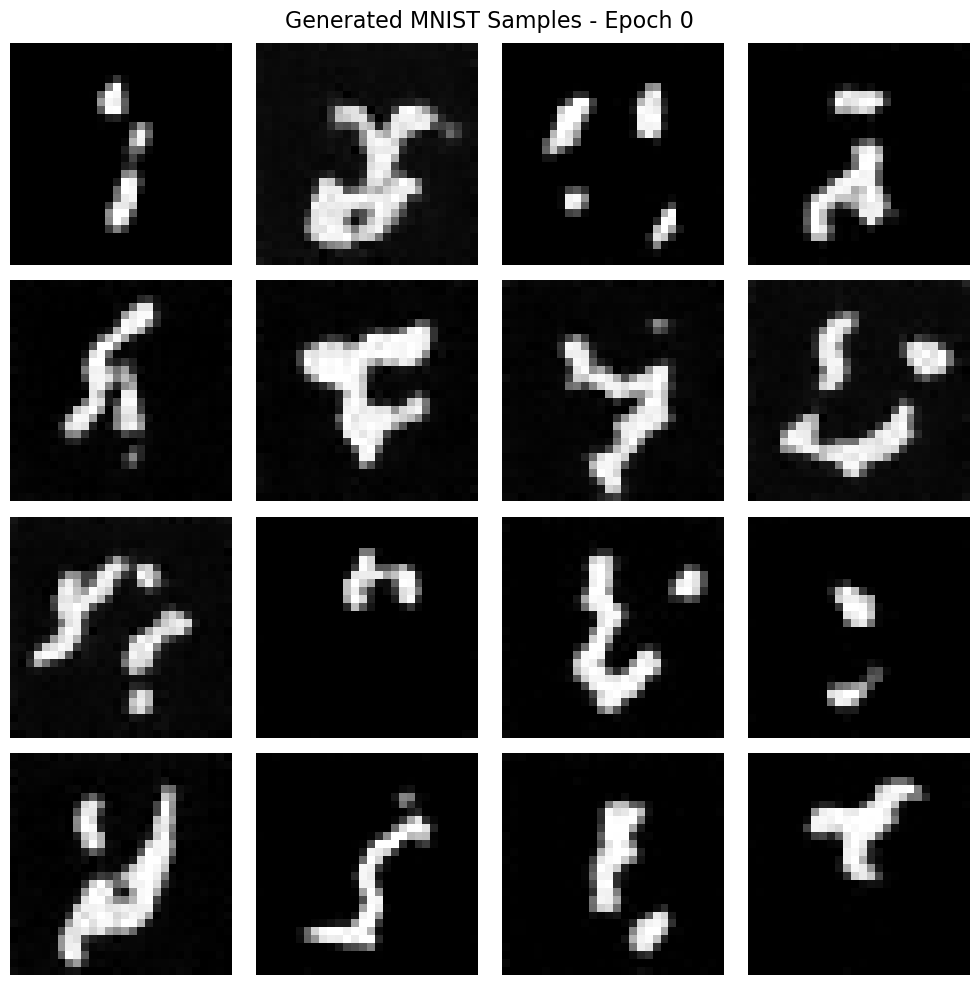

Epoch 2/30 completed. Average loss: 0.0360


Epoch 3/30 completed. Average loss: 0.0309


Epoch 4/30 completed. Average loss: 0.0292


Epoch 5/30 completed. Average loss: 0.0277


Epoch 6/30 completed. Average loss: 0.0268

Generating 16 samples at epoch 5...


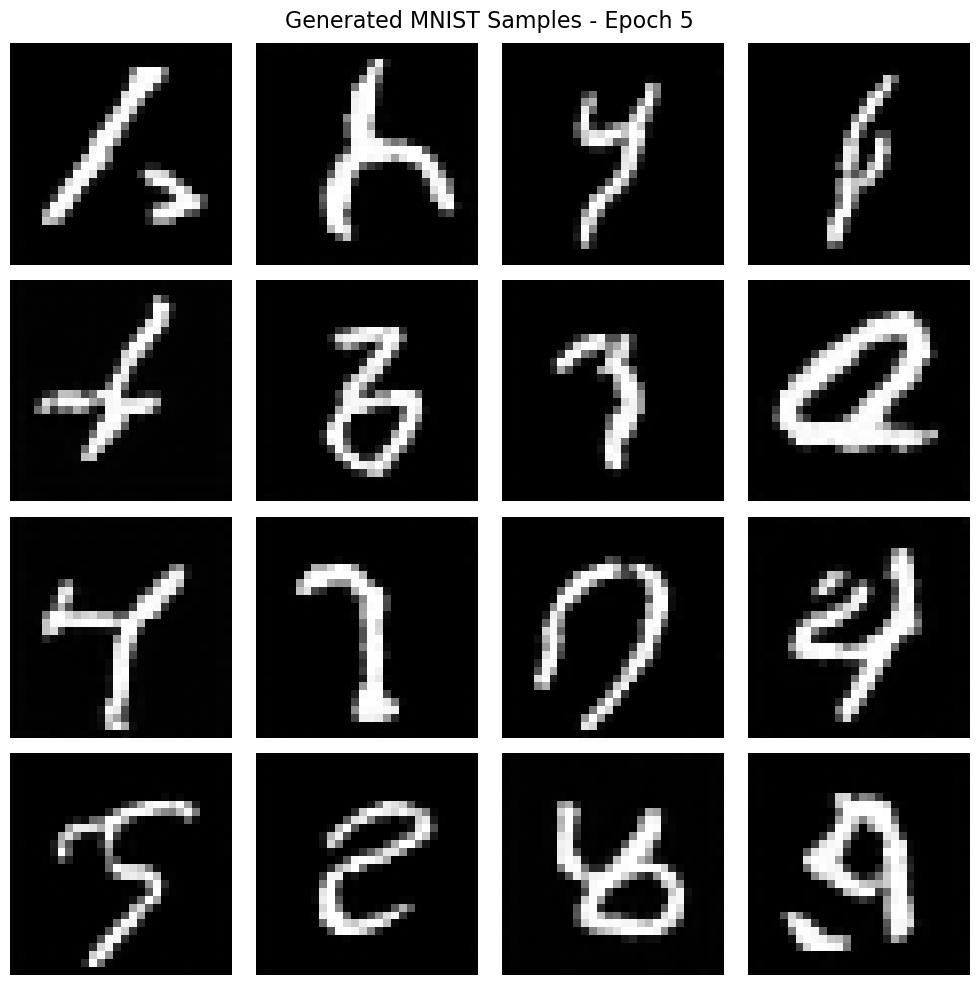

Epoch 7/30 completed. Average loss: 0.0261


Epoch 8/30 completed. Average loss: 0.0258


Epoch 9/30 completed. Average loss: 0.0253


Epoch 10/30 completed. Average loss: 0.0251


Epoch 11/30 completed. Average loss: 0.0248

Generating 16 samples at epoch 10...


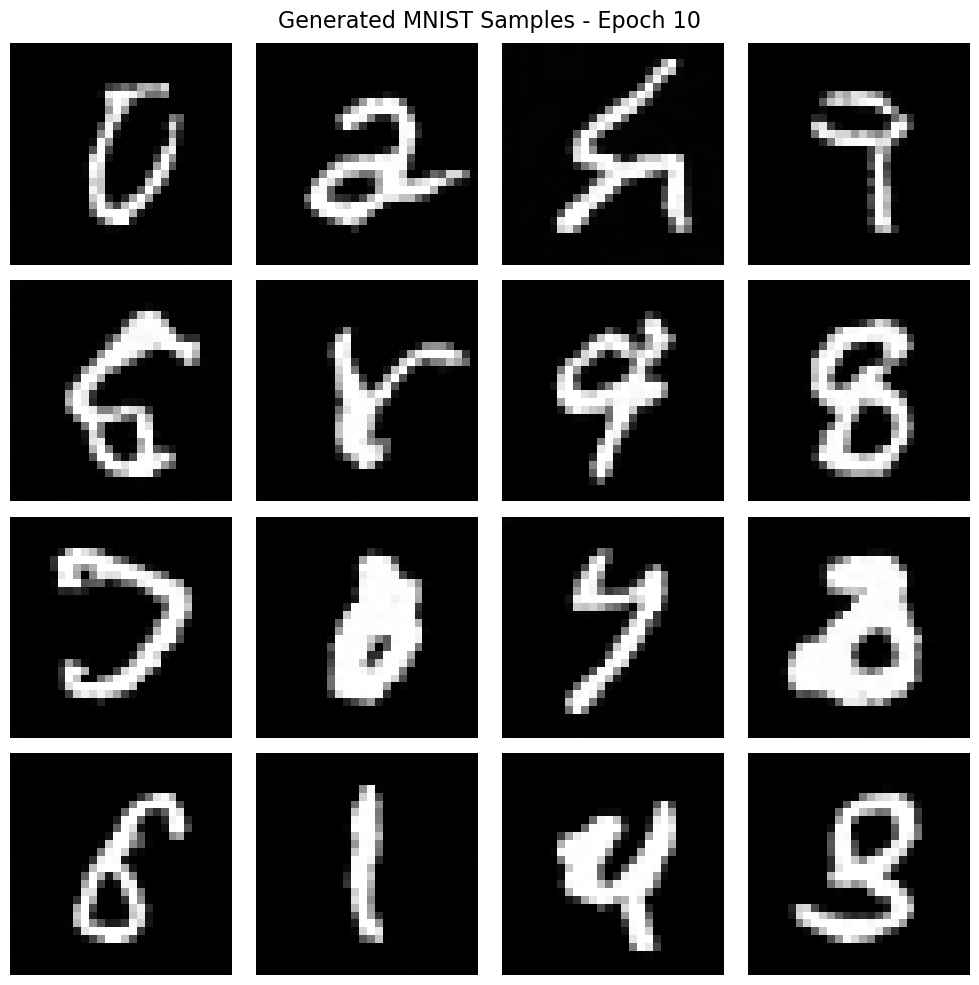

Epoch 12/30 completed. Average loss: 0.0247


Epoch 13/30 completed. Average loss: 0.0244


Epoch 14/30 completed. Average loss: 0.0240


Epoch 15/30 completed. Average loss: 0.0239


Epoch 16/30 completed. Average loss: 0.0239

Generating 16 samples at epoch 15...


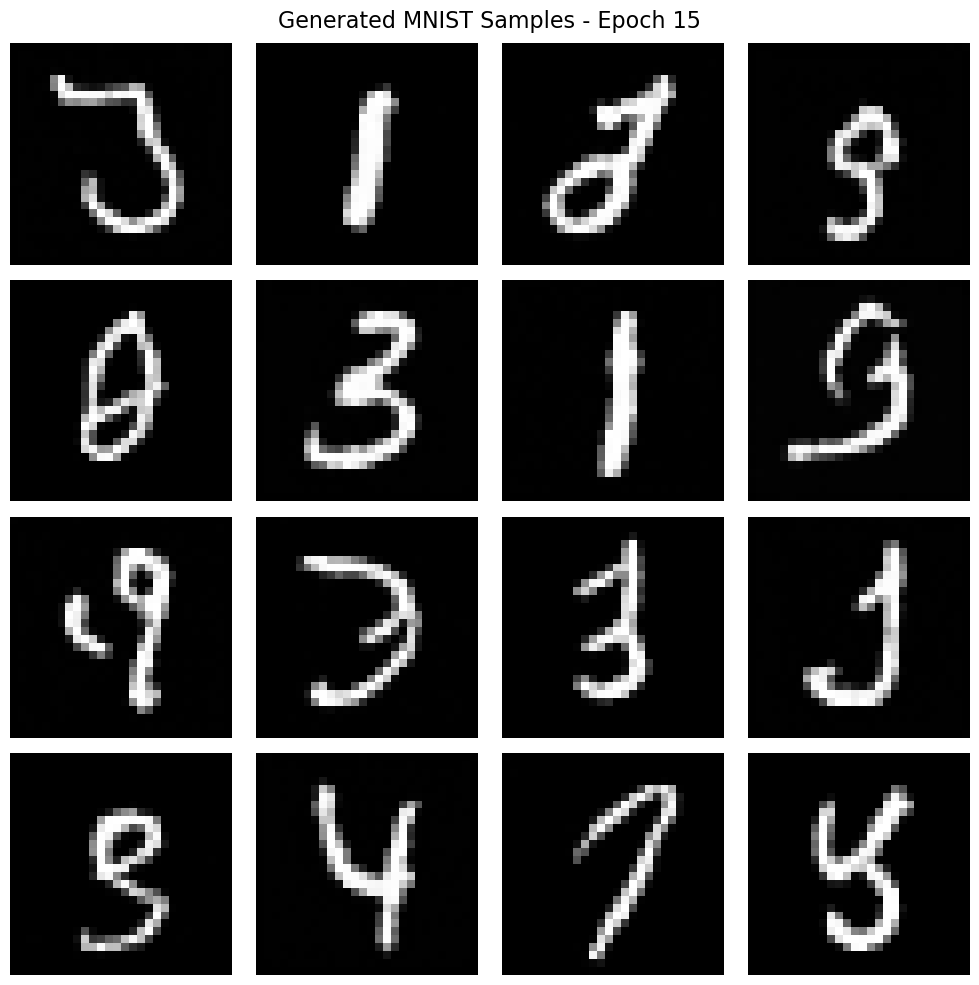

Epoch 17/30 completed. Average loss: 0.0238


Epoch 18/30 completed. Average loss: 0.0233


Epoch 19/30 completed. Average loss: 0.0232


Epoch 20/30 completed. Average loss: 0.0229


Epoch 21/30 completed. Average loss: 0.0230

Generating 16 samples at epoch 20...


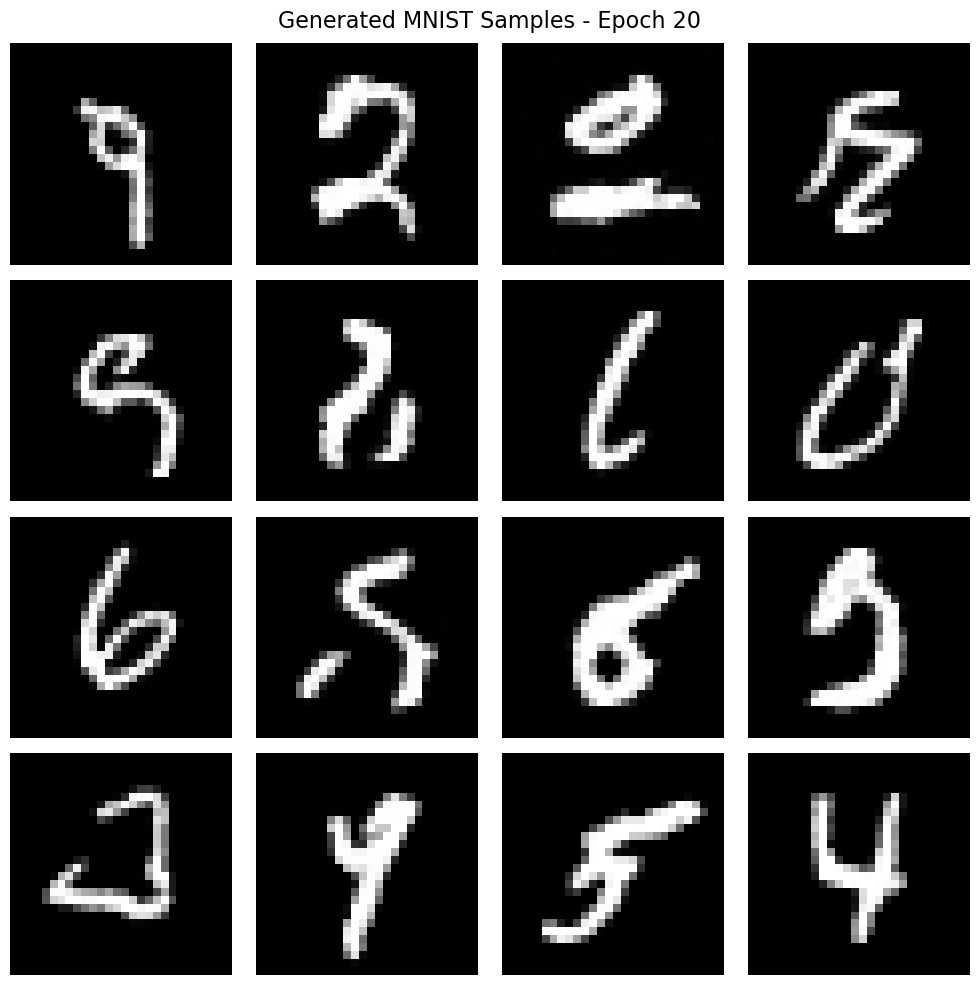

Epoch 22/30 completed. Average loss: 0.0232


Epoch 23/30 completed. Average loss: 0.0228


Epoch 24/30 completed. Average loss: 0.0229


Epoch 25/30 completed. Average loss: 0.0230


Epoch 26/30 completed. Average loss: 0.0228

Generating 16 samples at epoch 25...


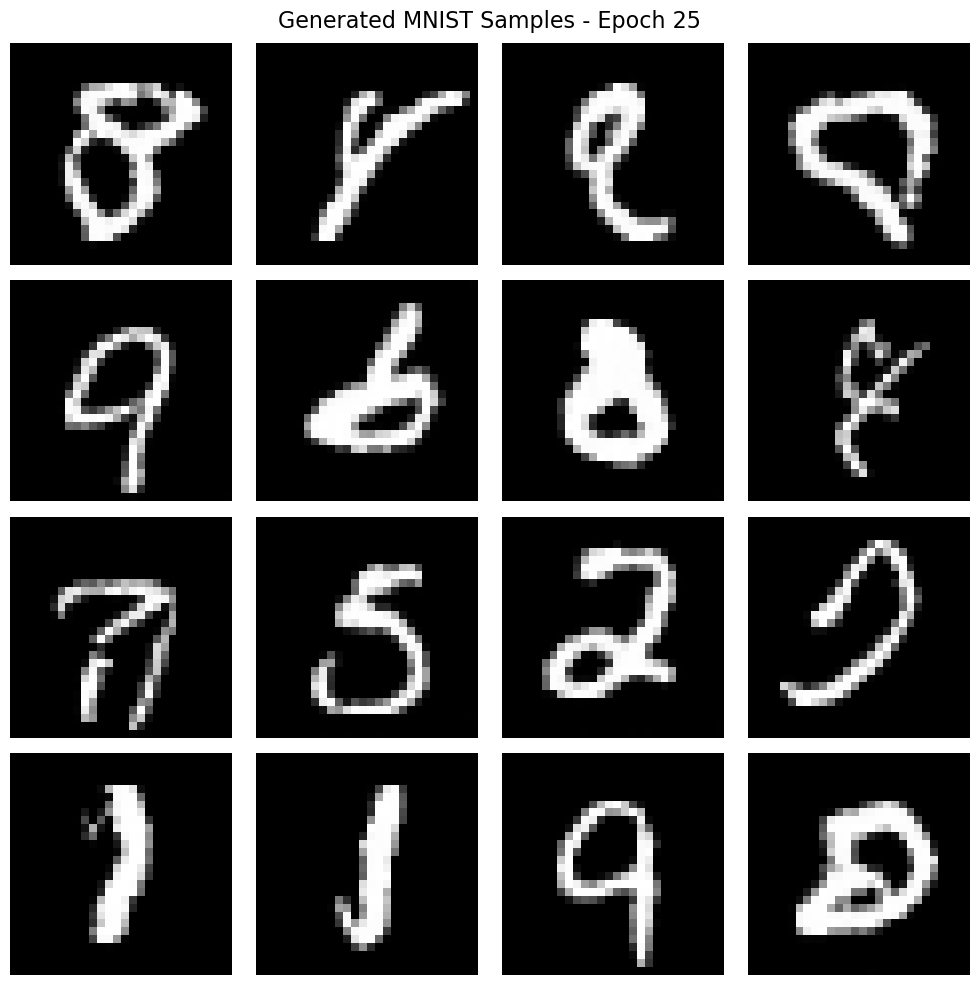

Epoch 27/30 completed. Average loss: 0.0225


Epoch 28/30 completed. Average loss: 0.0225


Epoch 29/30 completed. Average loss: 0.0227


Epoch 30/30 completed. Average loss: 0.0226


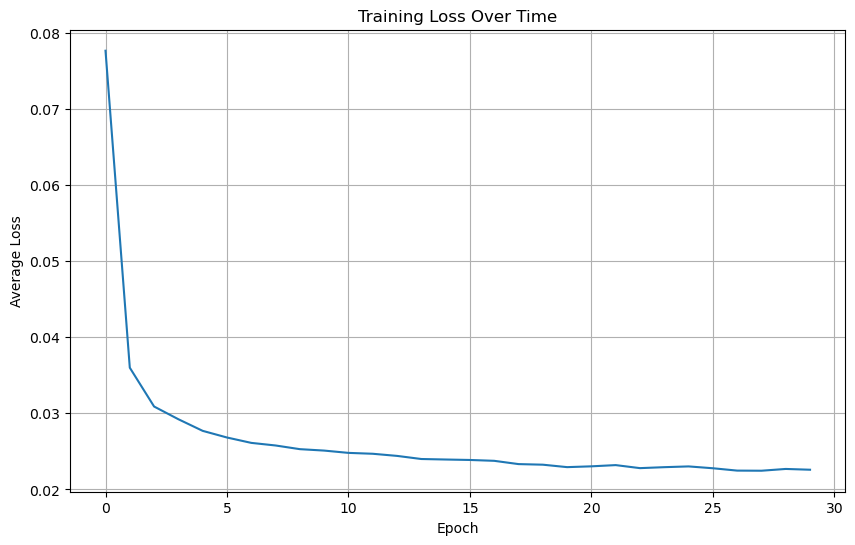


Generating final 25 samples...


2025-05-31 03:06:37.898012: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-05-31 03:06:40.844820: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-05-31 03:06:44.287825: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


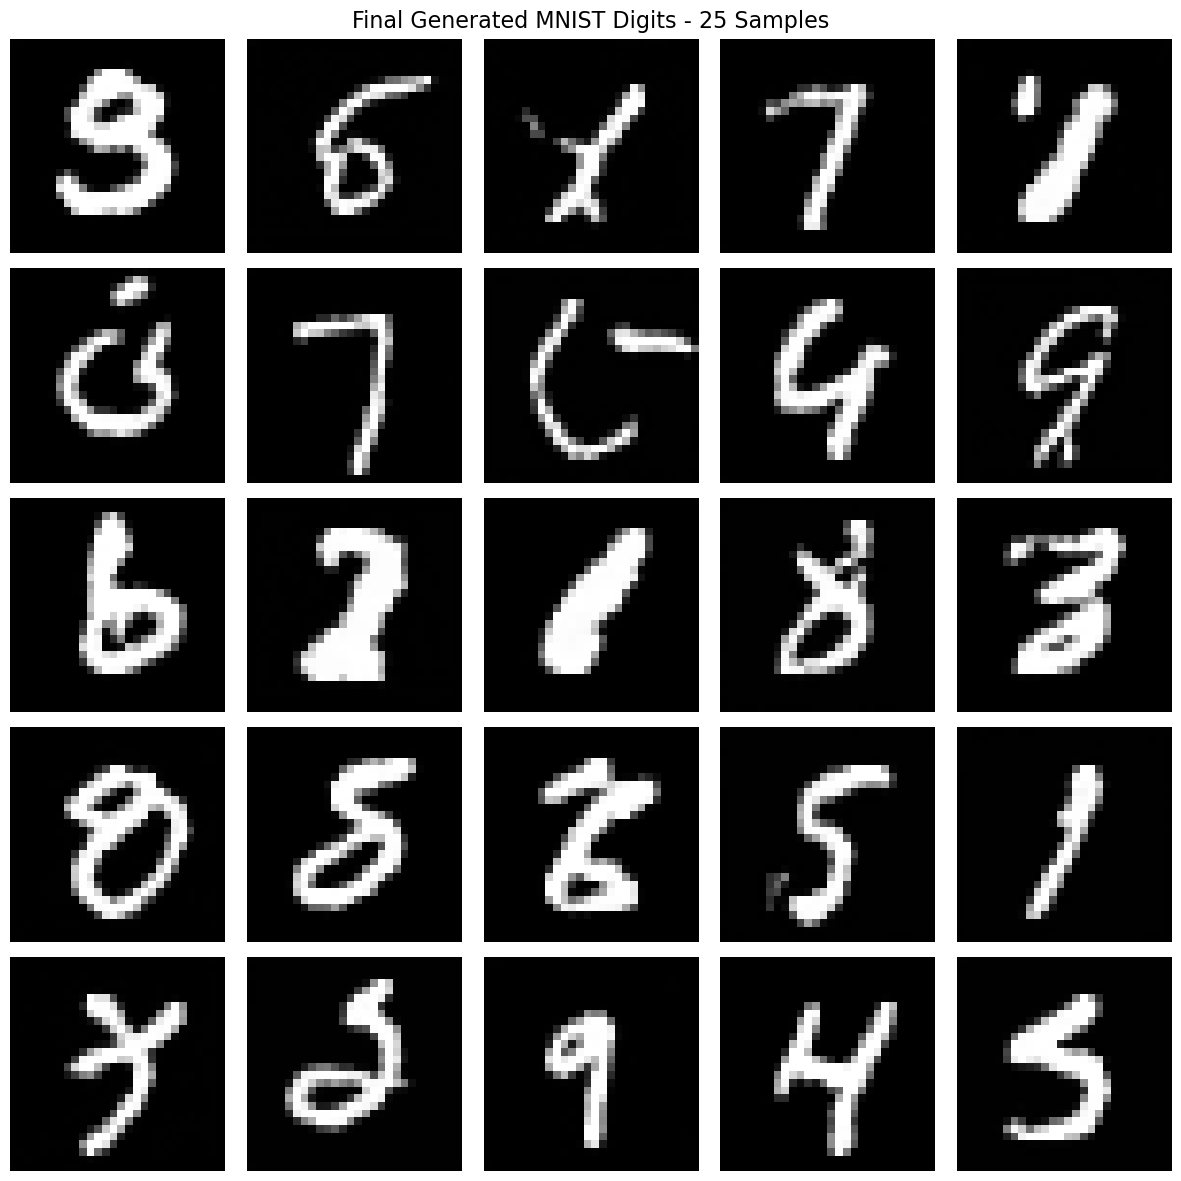

In [9]:
if __name__ == "__main__":
    main()